In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from scipy.stats import norm
import matplotlib.pyplot as plt

# Loading Dataset

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


# Build NN (bias=0)

In [3]:
class CustomizableNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, num_layers, use_bias):
        super(CustomizableNN, self).__init__()

        # Validate input
        assert num_layers == len(hidden_sizes), "Number of hidden layers should match the length of hidden_sizes."

        # Input layer
        layers = [nn.Linear(input_size, hidden_sizes[0], bias=use_bias), nn.ReLU()]

        # Hidden layers
        for i in range(1, num_layers):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i], bias=use_bias), nn.ReLU()]

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size, bias=use_bias))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage:
input_size = 28 * 28
output_size = 10
# hidden_sizes = [512, 256, 128, 64]
hidden_sizes = [16, 16, 16, 16]
num_layers = len(hidden_sizes)
use_bias = 0

# Create a customizable neural network
model = CustomizableNN(input_size, output_size, hidden_sizes, num_layers, use_bias)

# Loss cross entropy

In [4]:
# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


# # Training the model
# num_epochs = 4  # Reduce the number of epochs for demonstration purposes
# for epoch in range(num_epochs):
#     for inputs, labels in train_loader:
#         # Forward pass
#         outputs = model(inputs.view(-1, 28 * 28))
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Loss MSE

In [5]:
# Define Mean Squared Error (MSE) as the loss function
criterion = nn.MSELoss()

# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs.view(-1, 28 * 28))
        
        # Convert labels to one-hot encoding for MSE
        labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()

        # Compute MSE loss
        loss = criterion(outputs, labels_one_hot)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0229
Epoch [2/5], Loss: 0.0203
Epoch [3/5], Loss: 0.0266
Epoch [4/5], Loss: 0.0067
Epoch [5/5], Loss: 0.0069


# TEST

In [24]:
# Test the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.view(-1, 28 * 28))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 91.34%


# Estimated parameters

In [7]:
# Print the result weights and biases of each layer
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    if 'weight' in name:
        print(f'Weights: {param.data}')
    elif 'bias' in name:
        print(f'Biases: {param.data}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Weights: tensor([[-0.0280, -0.0128, -0.0332,  ..., -0.0566, -0.0094, -0.0149],
        [ 0.0028, -0.0026, -0.0090,  ...,  0.0035, -0.0215,  0.0376],
        [ 0.0144,  0.0043,  0.0007,  ...,  0.0262,  0.0165, -0.0052],
        ...,
        [-0.0009,  0.0170, -0.0239,  ..., -0.0175, -0.0062,  0.0100],
        [ 0.0264, -0.0070,  0.0375,  ..., -0.0246, -0.0069,  0.0185],
        [ 0.0283, -0.0096,  0.0316,  ...,  0.0129,  0.0060, -0.0171]])
Layer: model.2.weight, Size: torch.Size([16, 16])
Weights: tensor([[-0.1531,  0.1654, -0.0839,  0.1376,  0.3233,  0.2070,  0.0031, -0.2197,
          0.1535,  0.0797,  0.1927,  0.0240,  0.0992,  0.5309,  0.0219,  0.3194],
        [ 0.2231, -0.1810,  0.5875, -0.1754,  0.0268,  0.0681,  0.0388, -0.2008,
         -0.0178, -0.1441,  0.2390, -0.0642,  0.1511, -0.1825, -0.0296,  0.2777],
        [-0.0590, -0.0224, -0.1761,  0.1086,  0.3155,  0.1343,  0.0767,  0.1796,
         -0.2052, -0.0202,  0.0254, -0.5

# Gradient loss of parameter

In [8]:
# Print the derivatives of the loss with respect to each parameter
for name, param in model.named_parameters():
    print(f'Layer: {name}, Size: {param.size()}')
    #print(f'Gradient: {param.grad}')
    print('='*20)

Layer: model.0.weight, Size: torch.Size([16, 784])
Layer: model.2.weight, Size: torch.Size([16, 16])
Layer: model.4.weight, Size: torch.Size([16, 16])
Layer: model.6.weight, Size: torch.Size([16, 16])
Layer: model.8.weight, Size: torch.Size([10, 16])


# Fisher Information

In [9]:
# Compute the diagonal approximation using the Fisher Information Matrix
def fisher_diagonal(model,i):
    all_gradients = [param.grad[i] for param in model.parameters()]
    grad_vector = torch.cat([g.contiguous().view(-1) for g in all_gradients])
    grad_vector = grad_vector.view(-1, 1)
#         for param, gradient in zip(model.parameters(), all_gradients):
#             print(f"Gradient of loss w.r.t. {param[i]}:")
#             print(gradient)
#             print()
#         print('='*20)
#         print(grad_vector)
    G=torch.transpose(grad_vector,0,1)
    F=torch.matmul(grad_vector,G)
    return F,G,grad_vector

# Process the output and labels as probability.

In [10]:
def prob(outputs,labels):
    # re-probability outputs
    mini, _ = torch.min(outputs.data, 1)

    re_outputs = outputs-mini.view(-1, 1)
    re_outputs_p = re_outputs/torch.sum(re_outputs,1).view(-1, 1)
    
    # re-probability labels
    _, predicted = torch.max(outputs.data, 1)
    num_elements = labels.numel()
    identity_matrix = torch.eye(10)
    re_labels_p = identity_matrix[labels] # set probability of labels
    return re_outputs_p, re_labels_p

# Confidence interval and Predictive interval

In [11]:
def confi_pred_interval(inputs, labels, model, a=0.025):
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs.view(-1, 28 * 28))
    re_outputs_p, re_labels_p = prob(outputs,labels)
    
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
    loss = torch.sum((re_outputs_p-re_labels_p)**2,1)/2
    
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = torch.sum((re_outputs_p-y_p)**2,1)/2
    
    for i in range(10):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H=torch.pinverse(F) #use the pseudo-inverse 
        w=torch.mm(G,H)
        w=torch.mm(w,grad_vector)
        
        
        # CI
        sigma_epsilon_squared = loss[i]/len(labels)
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
        print(f"interva size:{ci}")
        print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [12]:
for inputs, labels in test_loader:
    
    c, c_p, mu, y_p= confi_pred_interval(inputs, labels, model, a=0.025)
    break

number:0
interva size:tensor([[0.0570]], grad_fn=<MulBackward0>)
p interva size:0.1352112591266632
number:1
interva size:tensor([[0.0895]], grad_fn=<MulBackward0>)
p interva size:0.11021960526704788
number:2
interva size:tensor([[0.0528]], grad_fn=<MulBackward0>)
p interva size:0.1158863827586174
number:3
interva size:tensor([[0.0336]], grad_fn=<MulBackward0>)
p interva size:0.15197692811489105
number:4
interva size:tensor([[0.0167]], grad_fn=<MulBackward0>)
p interva size:0.16153159737586975
number:5
interva size:tensor([[0.0387]], grad_fn=<MulBackward0>)
p interva size:0.12141846120357513
number:6
interva size:tensor([[0.1033]], grad_fn=<MulBackward0>)
p interva size:0.0929383859038353
number:7
interva size:tensor([[0.0074]], grad_fn=<MulBackward0>)
p interva size:0.17244790494441986
number:8
interva size:tensor([[0.1111]], grad_fn=<MulBackward0>)
p interva size:0.05505194514989853
number:9
interva size:tensor([[0.0957]], grad_fn=<MulBackward0>)
p interva size:0.11599527299404144


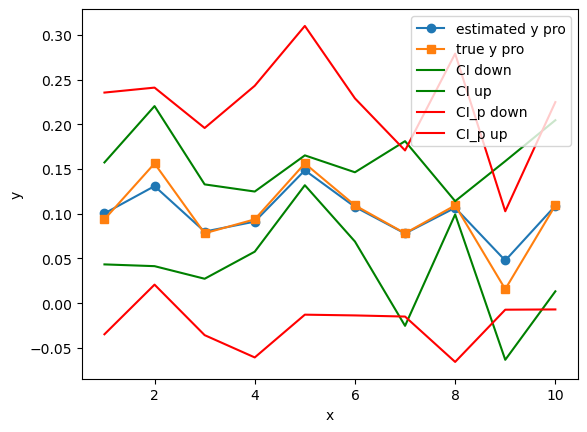

In [13]:
x_np = range(1, 11)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated y pro')
plt.plot(x_np, y_np, 's-', label='true y pro')
plt.plot(x_np, c_np[0,:,0], '-', label='CI down', color='green')
plt.plot(x_np, c_np[0,:,1], '-', label='CI up',color='green')
plt.plot(x_np, c_p_np[0,:,0], '-', label='CI_p down', color='red')
plt.plot(x_np, c_p_np[0,:,1], '-', label='CI_p up', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()


# Building NN (bias=unknown)

In [14]:
# # Define a neural network with 5 hidden layers
# class DeepNN(nn.Module):
#     def __init__(self):
#         super(DeepNN, self).__init__()
#         self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(28 * 28, 16)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(16, 16)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(16, 16)
#         self.relu3 = nn.ReLU()
#         self.fc4 = nn.Linear(16, 16)
#         self.relu4 = nn.ReLU()
#         self.fc5 = nn.Linear(16, 10)

#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.fc3(x)
#         x = self.relu3(x)
#         x = self.fc4(x)
#         x = self.relu4(x)
#         x = self.fc5(x)
#         return x

# # Initialize the model
# model_adj = DeepNN()

In [15]:
class DNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, num_layers, use_bias):
        super(DNN, self).__init__()

        # Validate input
        assert num_layers == len(hidden_sizes), "Number of hidden layers should match the length of hidden_sizes."

        # Input layer
        layers = [nn.Linear(input_size, hidden_sizes[0], bias=use_bias), nn.ReLU()]

        # Hidden layers
        for i in range(1, num_layers):
            layers += [nn.Linear(hidden_sizes[i - 1], hidden_sizes[i], bias=use_bias), nn.ReLU()]

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size, bias=use_bias))

        # Combine layers into a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example usage:
input_size = 28 * 28
output_size = 10
# hidden_sizes = [512, 256, 128, 64]
hidden_sizes = [16, 16, 16, 16]
num_layers = len(hidden_sizes)
use_bias = True

# Create a customizable neural network
model_adj = DNN(input_size, output_size, hidden_sizes, num_layers, use_bias)

In [16]:
# Define Mean Squared Error (MSE) as the loss function
criterion = nn.MSELoss()

# Use Adam optimizer
optimizer = optim.Adam(model_adj.parameters(), lr=0.001)

# Training the model
num_epochs = 5
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model_adj(inputs.view(-1, 28 * 28))
        
        # Convert labels to one-hot encoding for MSE
        labels_one_hot = nn.functional.one_hot(labels, num_classes=10).float()

        # Compute MSE loss
        loss = criterion(outputs, labels_one_hot)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0173
Epoch [2/5], Loss: 0.0258
Epoch [3/5], Loss: 0.0166
Epoch [4/5], Loss: 0.0102
Epoch [5/5], Loss: 0.0181


In [17]:
def Adjust(model_adj,num_layers):
    Adj = torch.tensor([])
    for i in range(10):
        F, G, grad_vector = fisher_diagonal(model_adj,i)
        F_in= torch.pinverse(F)
        r = len(F)
        l = num_layers+1
        Va = F_in[r-l:r,r-l:r]
        Vo = F_in[0:r-l,0:r-l]
        S = -F[0:r-l,r-l:r]
        D = torch.mm(Vo,S)
        D_t = torch.transpose(D,0,1)
        A = torch.mm(D,Va)
        A = torch.mm(A,D_t)
        Adj = torch.cat([Adj, A.unsqueeze(0)], 0)
    return Adj

In [18]:
for inputs, labels in train_loader:
    Adj= Adjust(model_adj,num_layers)
    break


In [19]:
def adj_confi_pred_interval(inputs, labels, model,Adj, a=0.025):
    Z= norm.ppf(1 - a / 2)
    c = torch.tensor([])
    c_p = torch.tensor([])
    outputs = model(inputs.view(-1, 28 * 28))
    re_outputs_p, re_labels_p = prob(outputs,labels)
    
    # loss for CI
    mu = torch.mean(re_outputs_p,dim=0) # mean of estimator of y
    loss = torch.sum((re_outputs_p-re_labels_p)**2,1)/2
    
    # loss for PI
    y_p = torch.mean(re_labels_p,dim=0)
    loss_p = torch.sum((re_outputs_p-y_p)**2,1)/2
    
    for i in range(10):
        print(f"number:{i}")
        print('='*20)
        F, G, grad_vector = fisher_diagonal(model,i)
        H = torch.pinverse(F) #use the pseudo-inverse 
        print(H)
        print(Adj[i])
        l=len(outputs)
        H = H + Adj[i]/l
        w = torch.mm(G,H)
        w = torch.mm(w,grad_vector)

        # CI
        sigma_epsilon_squared = loss[i]/len(labels)
        sigma=torch.sqrt(w*sigma_epsilon_squared)
        ci=sigma*Z
        CI= torch.cat([mu[i] - ci, mu[i] + ci],1)
        c = torch.cat([c, CI.unsqueeze(0)], 1) #combing the CI as squence
        print(ci)
        
        # PI
        sigma_epsilon_squared_p = loss_p[i]/len(labels)
        sigma_p=torch.sqrt(sigma_epsilon_squared_p)
        ci_p=sigma_p*Z
        ci_p_list=[mu[i] - ci_p, mu[i] + ci_p]
        ci_p_list=[tensor.view(1, 1) for tensor in ci_p_list]
        CI_p= torch.cat(ci_p_list,1)
        c_p = torch.cat([c_p, CI_p.unsqueeze(0)], 1) #combing the CI as squence
#         print('='*20)
#         print(f"fisher information matrix:{F}")
#         print(f"Inverse hessian:{H}")
#         print(f"mean of estimator probability:{mu[i]}")
#         print(f"interva size:{ci}")
#         print(f"p interva size:{ci_p}")
#         print(c)
    return c, c_p, mu, y_p

In [20]:
for inputs, labels in train_loader:
    Adj= Adjust(model_adj,num_layers)
    break
for inputs, labels in test_loader:
    adj_c, adj_c_p, mu, y_p= adj_confi_pred_interval(inputs, labels, model, Adj, a=0.025)
    c, c_p, mu, y_p= confi_pred_interval(inputs, labels, model, a=0.025)
    break

number:0
tensor([[ 5.3504e+09,  3.4330e+09, -4.0165e+08,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.3357e+08, -2.2887e+08,  3.4060e+07,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.5726e+08,  2.7070e+08,  9.7465e+07,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.9006e+10,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          4.9006e+10,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  4.9006e+10]])
tensor([[-4.9575e+10, -9.2028e+09, -1.2365e+11,  ..., -4.8712e+12,
          4.6240e+12,  4.2217e+12],
        [-9.2027e+09, -1.7083e+09, -2.2954e+10,  ..., -9.0426e+11,
          8.5837e+11,  7.8368e+11],
        [-1.2367e+11, -2.2957e+10, -3.0846e+11,  ..., -1.2152e+13,
          1.1535e+13,  1.0531e+13],
        ...,
        [-4.8720e+12, -9.0441e+11, -1

tensor([[2.7961e+10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 2.7961e+10, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 2.7961e+10,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.7961e+10, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 2.7961e+10,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         2.7961e+10]])
tensor([[ 1.3387e+19,  4.2097e+17, -1.5243e+17,  ...,  4.6504e+17,
          2.3663e+18,  1.8001e+18],
        [ 4.2097e+17,  1.3238e+16, -4.7934e+15,  ...,  1.4624e+16,
          7.4410e+16,  5.6607e+16],
        [-1.5243e+17, -4.7934e+15,  1.7357e+15,  ..., -5.2952e+15,
         -2.6944e+16, -2.0497e+16],
        ...,
        [ 4.6504e+17,  1.4624e+16, -5.2952e+15,  ...,  1.6155e+16,
          8.220

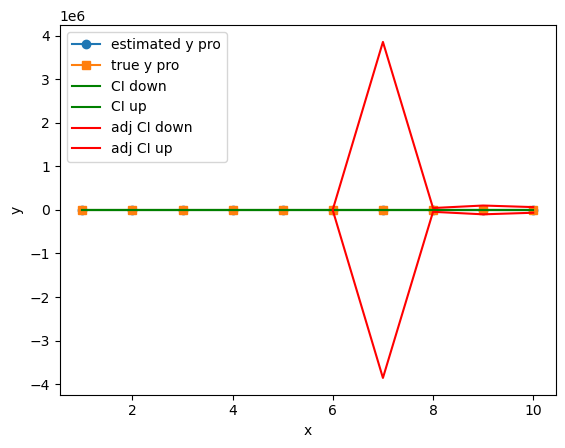

In [21]:
x_np = range(1, 11)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
adj_c_np = adj_c.detach().numpy()
adj_c_p_np = adj_c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated y pro')
plt.plot(x_np, y_np, 's-', label='true y pro')
plt.plot(x_np, c_np[0,:,0], '-', label='CI down', color='green')
plt.plot(x_np, c_np[0,:,1], '-', label='CI up',color='green')
plt.plot(x_np, adj_c_np[0,:,0], '-', label='adj CI down', color='red')
plt.plot(x_np, adj_c_np[0,:,1], '-', label='adj CI up',color='red')
plt.xlabel('x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()


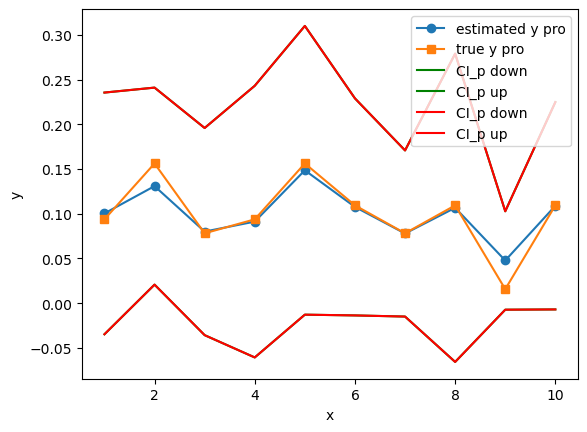

In [22]:
x_np = range(1, 11)
mu_np = mu.detach().numpy()
c_np = c.detach().numpy()
c_p_np = c_p.detach().numpy()
y_np = y_p.detach().numpy()
# Plotting with conditional formatting
plt.plot(x_np, mu_np, 'o-', label='estimated y pro')
plt.plot(x_np, y_np, 's-', label='true y pro')
plt.plot(x_np, c_p_np[0,:,0], '-', label='CI_p down', color='green')
plt.plot(x_np, c_p_np[0,:,1], '-', label='CI_p up', color='green')
plt.plot(x_np, adj_c_p_np[0,:,0], '-', label='CI_p down', color='red')
plt.plot(x_np, adj_c_p_np[0,:,1], '-', label='CI_p up', color='red')
plt.xlabel('x')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.show()
